# Cotton Plant Disease Detection 

# Import Labraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, optimizers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [3]:
data_path="/content/drive/MyDrive/Dataset"

In [4]:
train_data_path=os.path.join(data_path, 'Train Data')
val_data_path=os.path.join(data_path, 'Validation Data')
test_data_path=os.path.join(data_path, "Test Data")

In [5]:
names=os.listdir(train_data_path)
names

['fresh cotton leaf',
 'diseased cotton leaf',
 'fresh cotton plant',
 'diseased cotton plant']

In [6]:
def total_img(path,names):
    count=0
    for name in names:
        size=len(os.listdir(os.path.join(path, name)))
        count+=size
    return count

In [7]:
print("Total Training Images: ", total_img(train_data_path, names))
print("Total Validation Images: ", total_img(val_data_path, names))
print("Total Test Images: ", total_img(test_data_path, names))

Total Training Images:  1950
Total Validation Images:  324
Total Test Images:  18


# Data preprocessing

1 Read the picture files.

2 Decode the JPEG content to RGB grids of pixels.

3 Convert these into floating-point tensors.

4 Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

# Using ImageDataGenerator to read images from directories

# Setting up a data augmentation configuration via ImageDataGenerator

In [8]:
datagenerator=ImageDataGenerator(
                              rescale=1./255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              zoom_range=0.2,
                              shear_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest'
                            )

In [19]:
train_gen= datagenerator.flow_from_directory(
                                              train_data_path,
                                              batch_size=26,
                                              target_size=(150,150),
                                              class_mode='categorical'
                                            )

Found 1950 images belonging to 4 classes.


In [20]:
val_gen= datagenerator.flow_from_directory(
                                            val_data_path,
                                            target_size=(150,150),
                                            batch_size=12,
                                            class_mode='categorical'
                                        )

Found 324 images belonging to 4 classes.


In [21]:
labels=train_gen.class_indices
labels

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

# Displaying some randomly augmented training image

In [22]:
img_path='/content/drive/MyDrive/Dataset/Train Data/diseased cotton plant/dd (101)_iaip.jpg'

AxesImage(54,36;334.8x217.44)


(-0.5, 149.5, 149.5, -0.5)

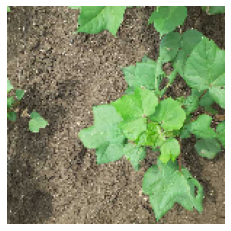

In [23]:
img=image.load_img(img_path, target_size=(150,150))

print(plt.imshow(img))
plt.axis('off')

In [14]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
print(x.shape)

(1, 150, 150, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


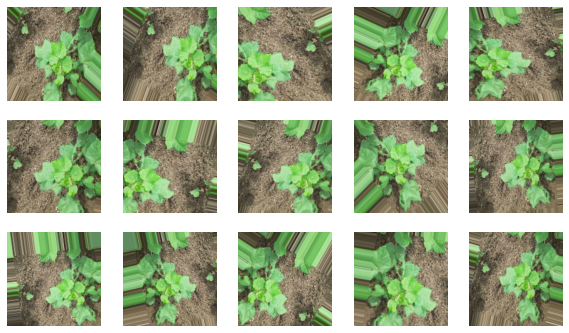

In [15]:
i=0
plt.figure(figsize=(10,10))
for k in range(15):
    for batch in datagenerator.flow(x, batch_size=1):
        plt.subplot(5,5, k+1)
        plt.imshow(image.array_to_img(batch[0]))
        plt.axis('off')
        i+=1
        if i%5==0:
            break

# Creating Network Architecture

In [5]:
model=models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [29]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback

In [30]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") is not None and logs.get('accuracy')>=0.97:
            print("\n Reached 97 accuracy so cancelling training")
            self.model.stop_training=True

callbacks=mycallback()

# 2nd Callback
#from tensorflow.keras.Callback import ModelCheckPoint
#model_save_path="E:/Study DATA/Deep learning Projects/Cotton Plant Disease Prediction"
#checkpoint=ModelCheckPoint(model_save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max' )

# Training

In [31]:
history=model.fit(train_gen, steps_per_epoch=75, epochs=300, validation_data=val_gen, validation_steps=27, callbacks=[callbacks])

Epoch 1/300
75/75 [==============================] - 653s 9s/step - loss: 1.2459 - accuracy: 0.4364 - val_loss: 1.1573 - val_accuracy: 0.3951
Epoch 2/300
75/75 [==============================] - 35s 471ms/step - loss: 1.0933 - accuracy: 0.5200 - val_loss: 1.0446 - val_accuracy: 0.5278
Epoch 3/300
75/75 [==============================] - 34s 460ms/step - loss: 1.0159 - accuracy: 0.5544 - val_loss: 1.0121 - val_accuracy: 0.4784
Epoch 4/300
75/75 [==============================] - 34s 452ms/step - loss: 0.9538 - accuracy: 0.5708 - val_loss: 0.9177 - val_accuracy: 0.5463
Epoch 5/300
75/75 [==============================] - 35s 470ms/step - loss: 0.8960 - accuracy: 0.6195 - val_loss: 0.8974 - val_accuracy: 0.6204
Epoch 6/300
75/75 [==============================] - 34s 454ms/step - loss: 0.8783 - accuracy: 0.6251 - val_loss: 0.9001 - val_accuracy: 0.5772
Epoch 7/300
75/75 [==============================] - 33s 444ms/step - loss: 0.8366 - accuracy: 0.6559 - val_loss: 0.8698 - val_accuracy: 0

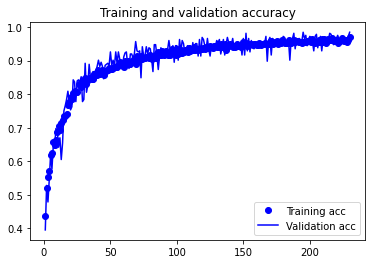

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

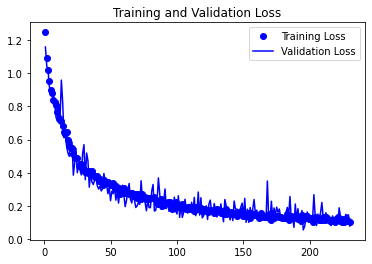

In [33]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs= range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss" )
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [34]:
model.save("/content/drive/MyDrive/Dataset/Cotton Plant Disease Predications Model New.h5")

In [35]:
testdatagen=ImageDataGenerator(rescale=1./255)

In [36]:
test_generator=testdatagen.flow_from_directory(
                                            test_data_path,
                                            batch_size=3,
                                            target_size=(150,150),
                                            class_mode='categorical'
                                            )

Found 18 images belonging to 4 classes.


In [37]:
loss,acc= model.evaluate(test_generator)

6/6 [==============================] - 11s 2s/step - loss: 0.1336 - accuracy: 0.9444


In [38]:
print("Test Data Loss: ",loss)
print("Test Data Accuracy: ",acc)

Test Data Loss:  0.1336437314748764
Test Data Accuracy:  0.9444444179534912


In [5]:
from tensorflow.keras.models import load_model

path=r"E:\Study DATA\Deep learning Projects\Cotton Plant Disease Prediction Project\cotton_model.h5"
model=load_model(path)

In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite = converter.convert()

with open(r"model.tflite", 'wb') as f:
    f.write(tflite)

INFO:tensorflow:Assets written to: C:\Users\TANZEE~1\AppData\Local\Temp\tmpw_a1jget\assets


INFO:tensorflow:Assets written to: C:\Users\TANZEE~1\AppData\Local\Temp\tmpw_a1jget\assets
